### Architecture
In this experiment swin tranformer tiny model is taken and applied on images with final head removal and single pawpularity output is added. In addition, Strong Augmentation is added to generalize the model including horizontal, vertical flipping, Random Rotation, Brightness, etc.
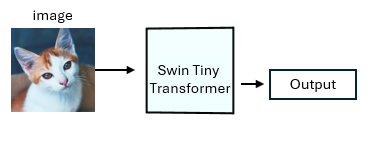

### Analysis
Swin models see the image as a set of tokens and uses multi‑head self‑attention to capture long‑range dependencies and global layout (how the pet, background, and other objects relate across the whole frame), whereas EfficientNet relies on local convolutions and pooling, which are less expressive for scene‑level images 
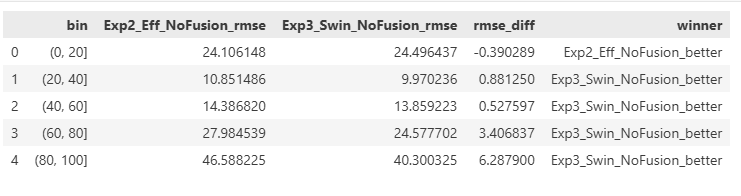

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

In [4]:
# imports and config
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import gc

gc.enable()

import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error

from src.config import EXP_CONFIGS
from src.utils import set_seed, save_config
from src.data import build_transforms, ImageOnlyDataset
from src.models import build_vision_backbone
from src.train import train_one_epoch_image, validate_image

main_folder = ".."
data_csv = os.path.join(main_folder, "data", "train.csv")
img_folder = os.path.join(main_folder, "data", "train")
out_dir = os.path.join(main_folder, "outputs", "exp3")

df = pd.read_csv(data_csv)
cfg = EXP_CONFIGS["exp3"]
TARGET = "Pawpularity"
os.makedirs(out_dir, exist_ok=True)
save_config(cfg, out_dir)
set_seed(cfg["seed"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/ghias/miniconda3/envs/rapids-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from src.train import run_single_fold
import time

kf = KFold(n_splits=cfg["n_splits"], shuffle=True, random_state=cfg["seed"])
oof_pred = np.zeros(len(df))
oof_true = df[TARGET].values
fold_index = np.full(len(df), -1, dtype=int)
fold_rmse = []

start_all = time.time()
for fold, (tr_idx, val_idx) in enumerate(kf.split(df), start=1):
    print(f"\n=== {cfg['name']}: Fold {fold} ===")
    train_df = df.iloc[tr_idx].reset_index(drop=True)
    val_df   = df.iloc[val_idx].reset_index(drop=True)

    best_rmse, val_preds, val_targets, val_ids = run_single_fold(
        fold=fold,
        train_df=train_df,
        val_df=val_df,
        img_folder=img_folder,
        cfg=cfg,
        out_dir=out_dir,
        device=device,
        mode="image",
        tab_cols=None,
        workers=16,
        pin_memory=True,
        persistent_workers=True,
    )

    oof_pred[val_idx] = val_preds
    fold_index[val_idx] = fold
    fold_rmse.append(best_rmse)
    print(f"Fold {fold} best RMSE: {best_rmse:.4f}")


all_sec = time.time() - start_all
print(f"\nTotal training time: {int(all_sec//60)}m {int(all_sec%60)}s")
# final metrics + OOF with fold column
oof_rmse = root_mean_squared_error(oof_true, oof_pred)
fold_rmse = np.array(fold_rmse)
print(f"\nOOF RMSE: {oof_rmse:.4f}")
print(f"Fold RMSEs: {fold_rmse.tolist()}  Mean={fold_rmse.mean():.4f}  Std={fold_rmse.std():.4f}")

oof_df = pd.DataFrame({
    "Id": df["Id"],
    "fold": fold_index,      
    "ytrue": oof_true,
    "oof_pred": oof_pred,
})
oof_df["abs_err"] = (oof_df["ytrue"] - oof_df["oof_pred"]).abs()
oof_df.to_csv(os.path.join(out_dir, "oof_detail.csv"), index=False)
oof_df.sort_values("abs_err", ascending=False).head(50).to_csv(
    os.path.join(out_dir, "top50_errors.csv"), index=False
)

np.save(os.path.join(out_dir, "oof_pred.npy"), oof_pred)
np.save(os.path.join(out_dir, "fold_rmse.npy"), fold_rmse)
with open(os.path.join(out_dir, "metrics.txt"), "w") as f:
    f.write(f"OOF_RMSE: {oof_rmse:.4f}\n")
    f.write(f"Fold_RMSE: {fold_rmse.tolist()}\nMean: {fold_rmse.mean():.4f}\nStd: {fold_rmse.std():.4f}\n")



=== Exp3_SwinT_384_Strong: Fold 1 ===
Epoch 1/10 | Fold 1 | Train[BCE]: Loss=0.6505 | ValRMSE: 18.0356
Epoch 2/10 | Fold 1 | Train[BCE]: Loss=0.6415 | ValRMSE: 18.0286
Epoch 3/10 | Fold 1 | Train[BCE]: Loss=0.6338 | ValRMSE: 17.9100
Epoch 4/10 | Fold 1 | Train[BCE]: Loss=0.6256 | ValRMSE: 18.0279
Epoch 5/10 | Fold 1 | Train[BCE]: Loss=0.6150 | ValRMSE: 18.2700
Epoch 6/10 | Fold 1 | Train[BCE]: Loss=0.6061 | ValRMSE: 18.5831
Epoch 7/10 | Fold 1 | Train[BCE]: Loss=0.5993 | ValRMSE: 18.6667
Epoch 8/10 | Fold 1 | Train[BCE]: Loss=0.5943 | ValRMSE: 18.8808
Early stopping at epoch 8
Fold 1 best RMSE: 17.9100

=== Exp3_SwinT_384_Strong: Fold 2 ===
Epoch 1/10 | Fold 2 | Train[BCE]: Loss=0.6486 | ValRMSE: 18.4088
Epoch 2/10 | Fold 2 | Train[BCE]: Loss=0.6381 | ValRMSE: 18.3921
Epoch 3/10 | Fold 2 | Train[BCE]: Loss=0.6300 | ValRMSE: 17.9829
Epoch 4/10 | Fold 2 | Train[BCE]: Loss=0.6214 | ValRMSE: 18.4003
Epoch 5/10 | Fold 2 | Train[BCE]: Loss=0.6102 | ValRMSE: 18.6317
Epoch 6/10 | Fold 2 | Tra

In [16]:
import pandas
df = pd.read_csv(out_dir+"/oof_detail.csv")
fold_rmse = []

for fold in range(1, 6):
    sub = df[df.fold == fold]
    rmse = ((sub.ytrue - sub.oof_pred)**2).mean() ** 0.5
    fold_rmse.append(rmse)
    print(f"Fold {fold} OOF RMSE: {rmse:.4f} (n={len(sub)})")

Fold 1 OOF RMSE: 17.9100 (n=1983)
Fold 2 OOF RMSE: 17.9829 (n=1983)
Fold 3 OOF RMSE: 17.1585 (n=1982)
Fold 4 OOF RMSE: 17.4974 (n=1982)
Fold 5 OOF RMSE: 18.0091 (n=1982)


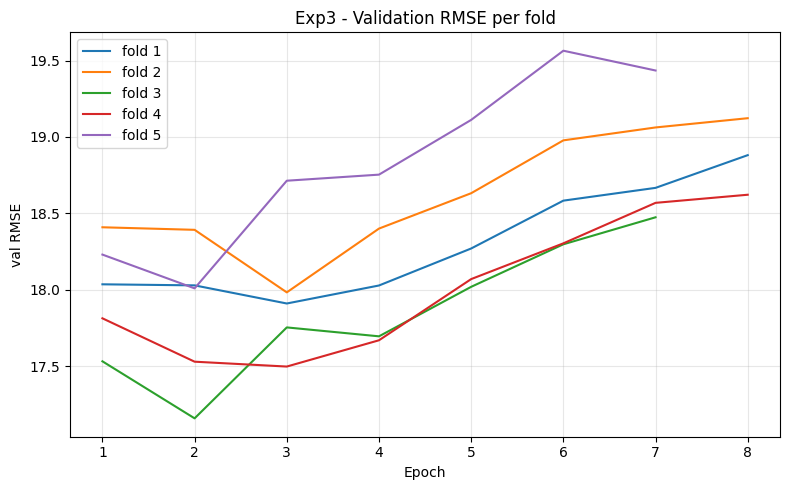

In [17]:
from src.plot import plot_all_folds_history
plot_all_folds_history(out_dir, folds=[1,2,3,4,5], title_prefix="Exp3")

In [18]:
#  Inspect worst error rows

errors_path = os.path.join(out_dir, "top50_errors.csv")
err_df = pd.read_csv(errors_path)
err_df.head()


Id  fold  ytrue   oof_pred    abs_err
0  4c1e05895368c997fdd709bbd1ac3dae     2      2  89.910660  87.910660
1  054cef9194f1a4513dc0965893b589bf     3      2  81.356499  79.356499
2  fa6a53f962225c17b22392748f91f9ac     2      4  81.770660  77.770660
3  3d946559e2b4b210a06e9103b0dd72e9     2      5  82.012764  77.012764
4  1e59bc4bf0f630df8f17fb908b7c13c2     1    100  25.165144  74.834856

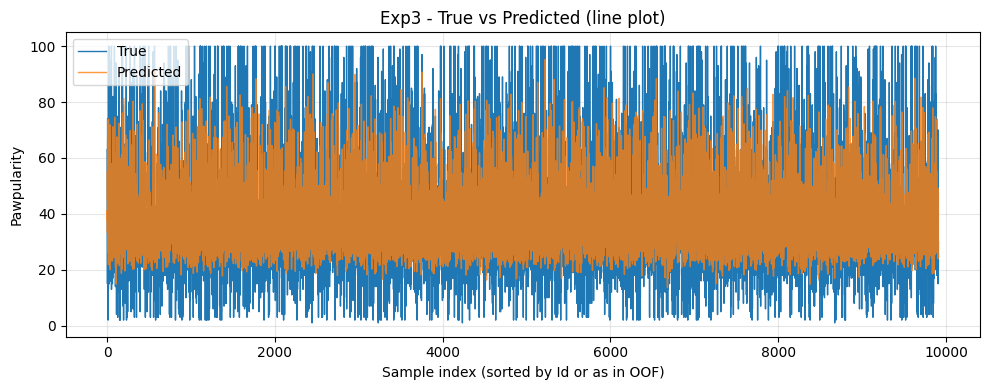

In [7]:
import os
import pandas as pd
from src.plot import (
   plot_oof_true_pred_lines,
    show_images_grid,
)

# Load OOF detail and top-errors
oof_df = pd.read_csv(os.path.join(out_dir, "oof_detail.csv"))
err_df = pd.read_csv(os.path.join(out_dir, "top50_errors.csv"))

# Plots
plot_oof_true_pred_lines(oof_df, title_prefix="Exp3")





Exp2_Eff_NoFusion OOF RMSE: 19.177387932516293
Exp3_Swin_NoFusion OOF RMSE: 17.714745225456582
ΔRMSE (Exp3_Swin_NoFusion - Exp2_Eff_NoFusion): -1.462642707059711


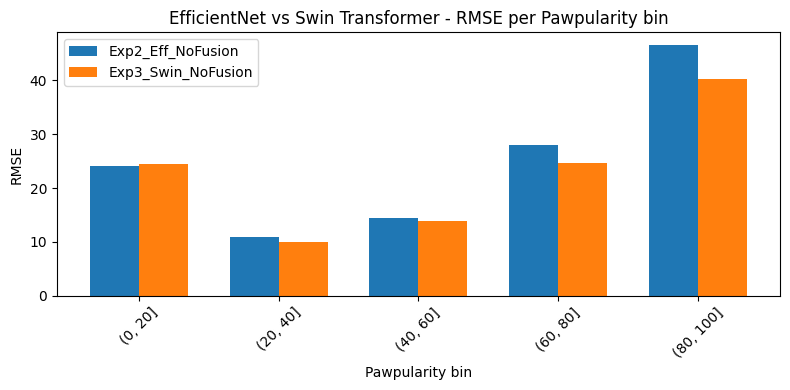

In [3]:
from src.plot import compare_oof_by_bins
bins = [0, 20, 40, 60, 80, 100]

df_bins, rmse3_all, rmse5_all, gap = compare_oof_by_bins(
    oof_path_a="../outputs/exp2/oof_detail.csv",
    oof_path_b="../outputs/exp3/oof_detail.csv",
    bins=bins,
    label_a="Exp2_Eff_NoFusion",
    label_b="Exp3_Swin_NoFusion",
    title_prefix="EfficientNet vs Swin Transformer",
)

In [4]:
df_bins.head()

bin  Exp2_Eff_NoFusion_rmse  Exp3_Swin_NoFusion_rmse  rmse_diff  \
0    (0, 20]               24.106148                24.496437  -0.390289   
1   (20, 40]               10.851486                 9.970236   0.881250   
2   (40, 60]               14.386820                13.859223   0.527597   
3   (60, 80]               27.984539                24.577702   3.406837   
4  (80, 100]               46.588225                40.300325   6.287900   

                      winner  
0   Exp2_Eff_NoFusion_better  
1  Exp3_Swin_NoFusion_better  
2  Exp3_Swin_NoFusion_better  
3  Exp3_Swin_NoFusion_better  
4  Exp3_Swin_NoFusion_better

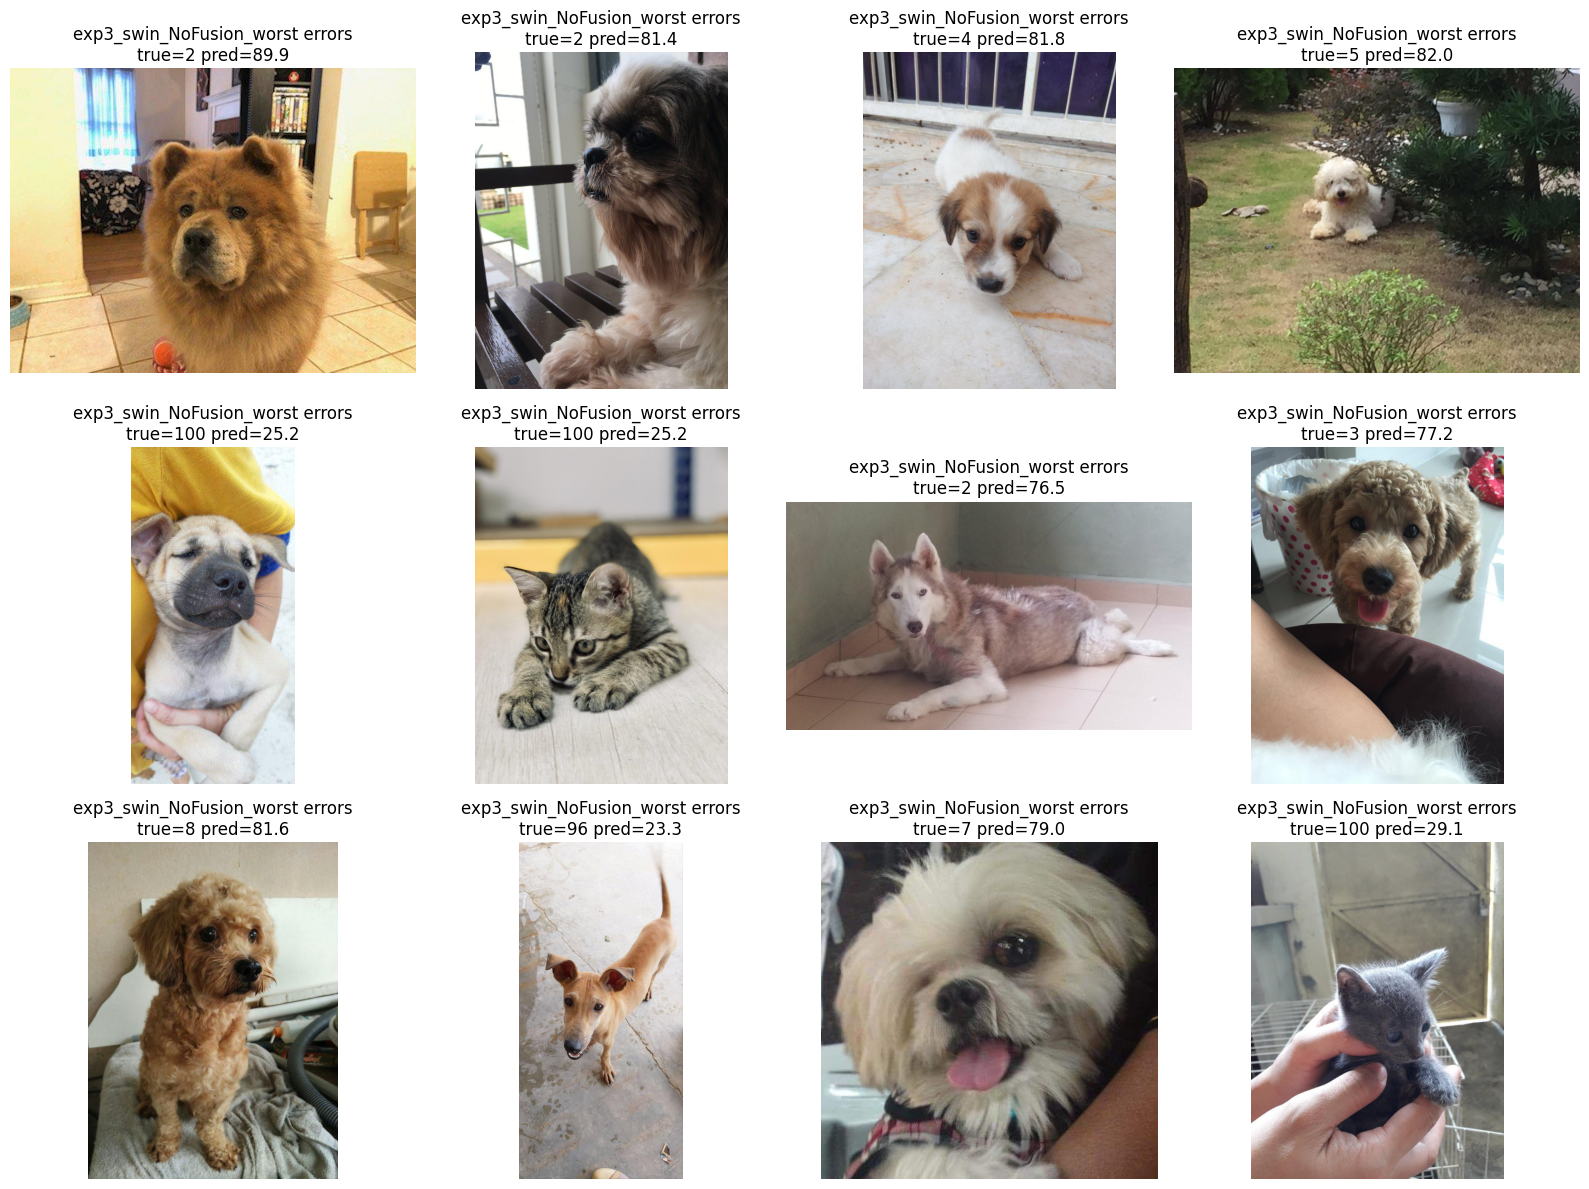

In [8]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_images_grid(err_df, img_folder, n=12, title_prefix="exp3_swin_NoFusion_worst errors")

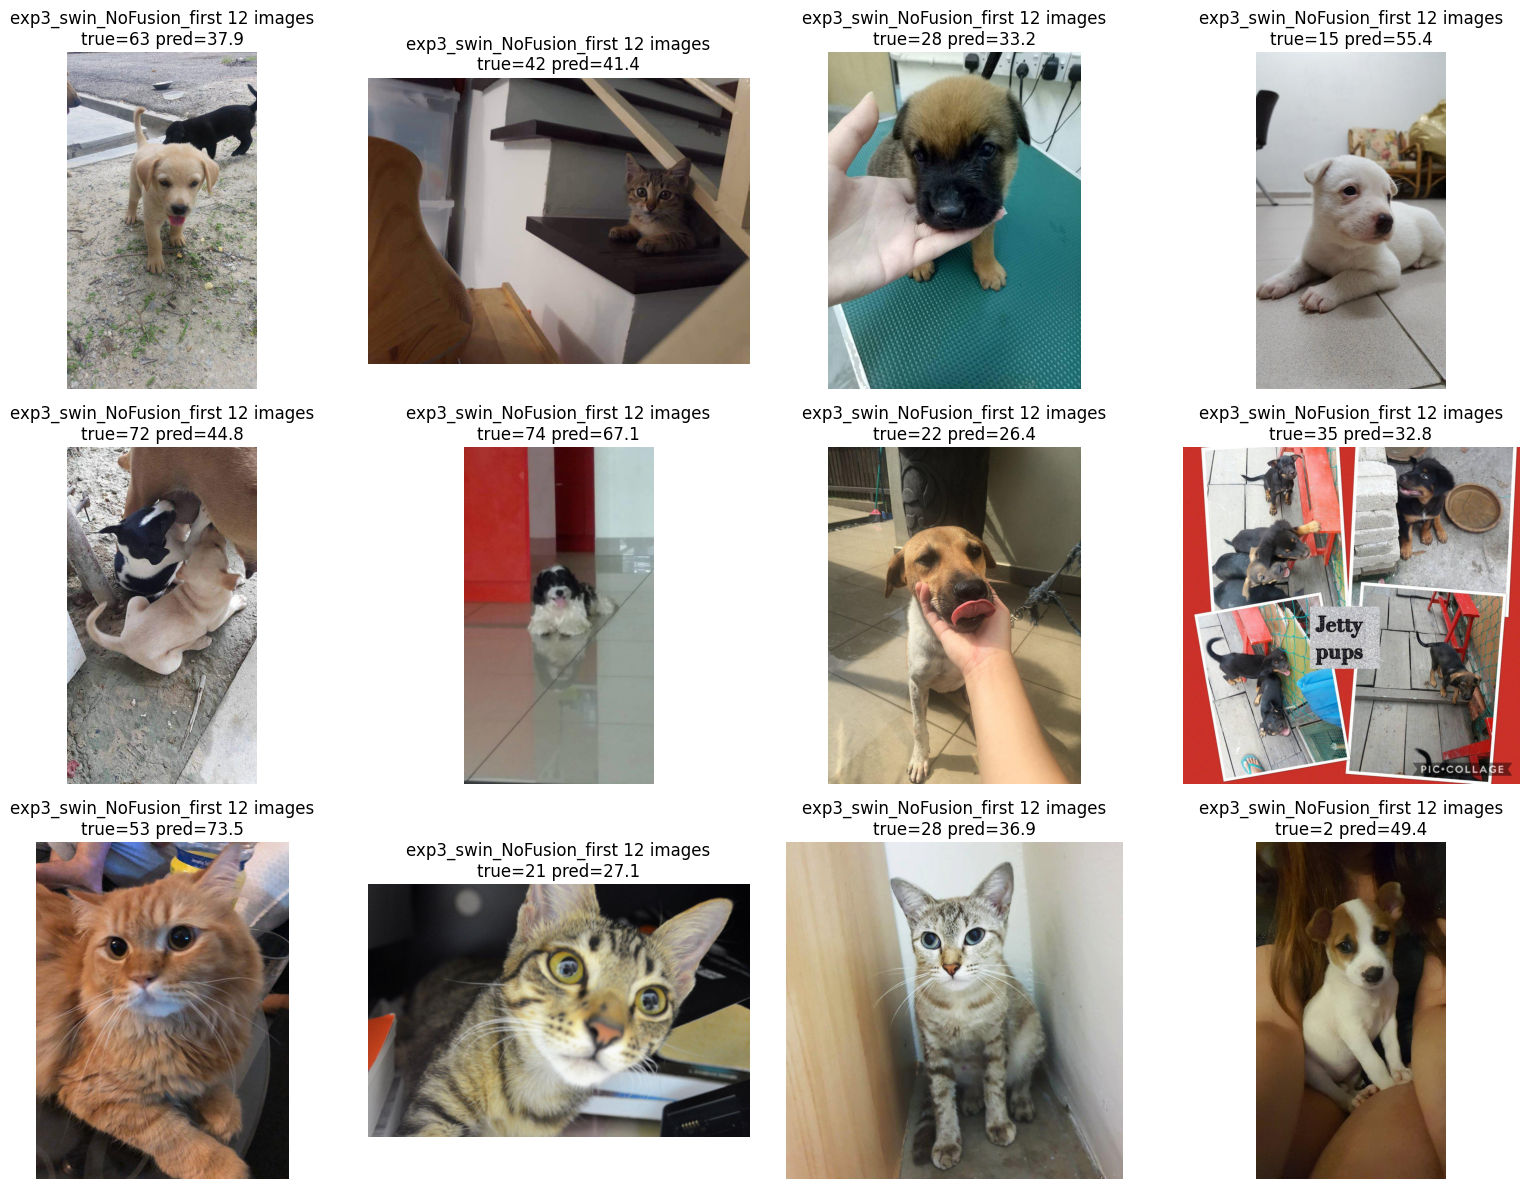

In [9]:
# Images of worst errors
img_folder = os.path.join(main_folder, "data", "train")
show_images_grid(oof_df, img_folder, n=12, title_prefix="exp3_swin_NoFusion_first 12 images")